<a href="https://colab.research.google.com/github/RafsanJany-44/Learning_Federated_Approch/blob/main/flower_TensoreFlow_Model_Save.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

df = pd.read_excel("/content/drive/MyDrive/Tanjila_mam/DS-Healthcare_version_2.xlsx")

In [15]:
df.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(888817, 13)

In [9]:
!pip install -q flwr["simulation"] tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 76.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 8.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.25.3 which is incompatible.


INFO flwr 2024-03-19 12:57:27,252 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=50, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=50, round_timeout=None)


<class 'numpy.ndarray'>


2024-03-19 12:57:32,024	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-19 12:57:34,740 | app.py:213 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 7730629019.0, 'object_store_memory': 3865314508.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 7730629019.0, 'object_store_memory': 3865314508.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0}
INFO flwr 2024-03-19 12:57:34,750 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-19 12:57:34,760 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO:flwr:Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2024-03-19 12:57:34,

-------------------________________________--------------- 50


(pid=20180) 2024-03-19 12:57:41.407548: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(DefaultActor pid=20180) /usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=20180)   client = check_clientfn_returns_client(client_fn(cid))
DEBUG flwr 2024-03-19 12:58:21,547 | server.py:236 | fit_round 1 received 10 results and 0 failures
DEBUG:flwr:fit_round 1 received 10 results and 0 failures
WARNING flwr 2024-03-19 12:58:21,585 | fedavg.py:250 | No fit_metrics_aggregation_fn provided
INFO flwr 2024-03-19 12:58:35,101 | server.py:125 | fit progress: (1, 115.40326690673828, {'accura

-------------------________________________--------------- 49


DEBUG flwr 2024-03-19 12:58:37,974 | server.py:187 | evaluate_round 1 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 5 results and 0 failures
DEBUG flwr 2024-03-19 12:58:37,980 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 2: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 12:58:54,925 | server.py:236 | fit_round 2 received 10 results and 0 failures
DEBUG:flwr:fit_round 2 received 10 results and 0 failures
INFO flwr 2024-03-19 12:59:09,118 | server.py:125 | fit progress: (2, 138.7212371826172, {'accuracy': 0.6888684034347534}, 63.36656505500014)
INFO:flwr:fit progress: (2, 138.7212371826172, {'accuracy': 0.6888684034347534}, 63.36656505500014)
DEBUG flwr 2024-03-19 12:59:09,124 | server.py:173 | evaluate_round 2: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 2: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 48


DEBUG flwr 2024-03-19 12:59:11,015 | server.py:187 | evaluate_round 2 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2024-03-19 12:59:11,018 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 3: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 12:59:26,850 | server.py:236 | fit_round 3 received 10 results and 0 failures
DEBUG:flwr:fit_round 3 received 10 results and 0 failures
INFO flwr 2024-03-19 12:59:47,789 | server.py:125 | fit progress: (3, 185.81167602539062, {'accuracy': 0.7205755114555359}, 102.03795605799996)
INFO:flwr:fit progress: (3, 185.81167602539062, {'accuracy': 0.7205755114555359}, 102.03795605799996)
DEBUG flwr 2024-03-19 12:59:47,794 | server.py:173 | evaluate_round 3: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 3: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 47


DEBUG flwr 2024-03-19 12:59:50,680 | server.py:187 | evaluate_round 3 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 5 results and 0 failures
DEBUG flwr 2024-03-19 12:59:50,686 | server.py:222 | fit_round 4: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 4: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:00:08,445 | server.py:236 | fit_round 4 received 10 results and 0 failures
DEBUG:flwr:fit_round 4 received 10 results and 0 failures
INFO flwr 2024-03-19 13:00:22,890 | server.py:125 | fit progress: (4, 273.548095703125, {'accuracy': 0.7673587799072266}, 137.13808674300026)
INFO:flwr:fit progress: (4, 273.548095703125, {'accuracy': 0.7673587799072266}, 137.13808674300026)
DEBUG flwr 2024-03-19 13:00:22,895 | server.py:173 | evaluate_round 4: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 4: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 46


DEBUG flwr 2024-03-19 13:00:24,759 | server.py:187 | evaluate_round 4 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:00:24,763 | server.py:222 | fit_round 5: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 5: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:00:40,434 | server.py:236 | fit_round 5 received 10 results and 0 failures
DEBUG:flwr:fit_round 5 received 10 results and 0 failures
INFO flwr 2024-03-19 13:00:55,705 | server.py:125 | fit progress: (5, 352.629150390625, {'accuracy': 0.7868875861167908}, 169.95299417000024)
INFO:flwr:fit progress: (5, 352.629150390625, {'accuracy': 0.7868875861167908}, 169.95299417000024)
DEBUG flwr 2024-03-19 13:00:55,713 | server.py:173 | evaluate_round 5: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 5: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 45


DEBUG flwr 2024-03-19 13:00:57,473 | server.py:187 | evaluate_round 5 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:00:57,481 | server.py:222 | fit_round 6: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 6: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:01:14,407 | server.py:236 | fit_round 6 received 10 results and 0 failures
DEBUG:flwr:fit_round 6 received 10 results and 0 failures
INFO flwr 2024-03-19 13:01:35,345 | server.py:125 | fit progress: (6, 435.7398986816406, {'accuracy': 0.784299910068512}, 209.59379473200033)
INFO:flwr:fit progress: (6, 435.7398986816406, {'accuracy': 0.784299910068512}, 209.59379473200033)
DEBUG flwr 2024-03-19 13:01:35,350 | server.py:173 | evaluate_round 6: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 6: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 44


DEBUG flwr 2024-03-19 13:01:37,235 | server.py:187 | evaluate_round 6 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:01:37,239 | server.py:222 | fit_round 7: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 7: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:01:53,220 | server.py:236 | fit_round 7 received 10 results and 0 failures
DEBUG:flwr:fit_round 7 received 10 results and 0 failures
INFO flwr 2024-03-19 13:02:06,578 | server.py:125 | fit progress: (7, 466.1918640136719, {'accuracy': 0.794521152973175}, 240.82690507799998)
INFO:flwr:fit progress: (7, 466.1918640136719, {'accuracy': 0.794521152973175}, 240.82690507799998)
DEBUG flwr 2024-03-19 13:02:06,584 | server.py:173 | evaluate_round 7: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 7: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 43


DEBUG flwr 2024-03-19 13:02:08,377 | server.py:187 | evaluate_round 7 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:02:08,380 | server.py:222 | fit_round 8: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 8: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:02:23,816 | server.py:236 | fit_round 8 received 10 results and 0 failures
DEBUG:flwr:fit_round 8 received 10 results and 0 failures
INFO flwr 2024-03-19 13:02:37,438 | server.py:125 | fit progress: (8, 529.5328979492188, {'accuracy': 0.7980907559394836}, 271.68662965700014)
INFO:flwr:fit progress: (8, 529.5328979492188, {'accuracy': 0.7980907559394836}, 271.68662965700014)
DEBUG flwr 2024-03-19 13:02:37,447 | server.py:173 | evaluate_round 8: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 8: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 42


DEBUG flwr 2024-03-19 13:02:39,300 | server.py:187 | evaluate_round 8 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:02:39,307 | server.py:222 | fit_round 9: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 9: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:02:56,509 | server.py:236 | fit_round 9 received 10 results and 0 failures
DEBUG:flwr:fit_round 9 received 10 results and 0 failures
INFO flwr 2024-03-19 13:03:10,059 | server.py:125 | fit progress: (9, 554.38916015625, {'accuracy': 0.7983601093292236}, 304.30740978300037)
INFO:flwr:fit progress: (9, 554.38916015625, {'accuracy': 0.7983601093292236}, 304.30740978300037)
DEBUG flwr 2024-03-19 13:03:10,066 | server.py:173 | evaluate_round 9: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 9: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 41


DEBUG flwr 2024-03-19 13:03:13,141 | server.py:187 | evaluate_round 9 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:03:13,150 | server.py:222 | fit_round 10: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 10: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:03:29,545 | server.py:236 | fit_round 10 received 10 results and 0 failures
DEBUG:flwr:fit_round 10 received 10 results and 0 failures
INFO flwr 2024-03-19 13:03:42,211 | server.py:125 | fit progress: (10, 595.566162109375, {'accuracy': 0.7984248995780945}, 336.45937078)
INFO:flwr:fit progress: (10, 595.566162109375, {'accuracy': 0.7984248995780945}, 336.45937078)
DEBUG flwr 2024-03-19 13:03:42,216 | server.py:173 | evaluate_round 10: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 10: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 40


DEBUG flwr 2024-03-19 13:03:44,848 | server.py:187 | evaluate_round 10 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:03:44,854 | server.py:222 | fit_round 11: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 11: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:04:00,434 | server.py:236 | fit_round 11 received 10 results and 0 failures
DEBUG:flwr:fit_round 11 received 10 results and 0 failures
INFO flwr 2024-03-19 13:04:14,561 | server.py:125 | fit progress: (11, 635.5489501953125, {'accuracy': 0.7984214425086975}, 368.8095283810003)
INFO:flwr:fit progress: (11, 635.5489501953125, {'accuracy': 0.7984214425086975}, 368.8095283810003)
DEBUG flwr 2024-03-19 13:04:14,567 | server.py:173 | evaluate_round 11: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 11: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 39


DEBUG flwr 2024-03-19 13:04:16,404 | server.py:187 | evaluate_round 11 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 11 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:04:16,408 | server.py:222 | fit_round 12: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 12: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:04:33,459 | server.py:236 | fit_round 12 received 10 results and 0 failures
DEBUG:flwr:fit_round 12 received 10 results and 0 failures
INFO flwr 2024-03-19 13:04:54,345 | server.py:125 | fit progress: (12, 668.8458251953125, {'accuracy': 0.7984078526496887}, 408.59353396899996)
INFO:flwr:fit progress: (12, 668.8458251953125, {'accuracy': 0.7984078526496887}, 408.59353396899996)
DEBUG flwr 2024-03-19 13:04:54,349 | server.py:173 | evaluate_round 12: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 12: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 38


DEBUG flwr 2024-03-19 13:04:57,444 | server.py:187 | evaluate_round 12 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 12 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:04:57,448 | server.py:222 | fit_round 13: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 13: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:05:13,078 | server.py:236 | fit_round 13 received 10 results and 0 failures
DEBUG:flwr:fit_round 13 received 10 results and 0 failures
INFO flwr 2024-03-19 13:05:33,972 | server.py:125 | fit progress: (13, 686.3091430664062, {'accuracy': 0.7982953190803528}, 448.2208995440001)
INFO:flwr:fit progress: (13, 686.3091430664062, {'accuracy': 0.7982953190803528}, 448.2208995440001)
DEBUG flwr 2024-03-19 13:05:33,976 | server.py:173 | evaluate_round 13: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 13: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 37


DEBUG flwr 2024-03-19 13:05:35,774 | server.py:187 | evaluate_round 13 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 13 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:05:35,777 | server.py:222 | fit_round 14: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 14: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:05:51,237 | server.py:236 | fit_round 14 received 10 results and 0 failures
DEBUG:flwr:fit_round 14 received 10 results and 0 failures
INFO flwr 2024-03-19 13:06:04,444 | server.py:125 | fit progress: (14, 765.597900390625, {'accuracy': 0.7983942031860352}, 478.69236901199974)
INFO:flwr:fit progress: (14, 765.597900390625, {'accuracy': 0.7983942031860352}, 478.69236901199974)
DEBUG flwr 2024-03-19 13:06:04,450 | server.py:173 | evaluate_round 14: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 14: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 36


DEBUG flwr 2024-03-19 13:06:06,782 | server.py:187 | evaluate_round 14 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 14 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:06:06,786 | server.py:222 | fit_round 15: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 15: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:06:24,705 | server.py:236 | fit_round 15 received 10 results and 0 failures
DEBUG:flwr:fit_round 15 received 10 results and 0 failures
INFO flwr 2024-03-19 13:06:37,998 | server.py:125 | fit progress: (15, 781.2224731445312, {'accuracy': 0.7984657883644104}, 512.2462334639999)
INFO:flwr:fit progress: (15, 781.2224731445312, {'accuracy': 0.7984657883644104}, 512.2462334639999)
DEBUG flwr 2024-03-19 13:06:38,002 | server.py:173 | evaluate_round 15: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 15: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 35


DEBUG flwr 2024-03-19 13:06:40,850 | server.py:187 | evaluate_round 15 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 15 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:06:40,855 | server.py:222 | fit_round 16: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 16: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:06:56,984 | server.py:236 | fit_round 16 received 10 results and 0 failures
DEBUG:flwr:fit_round 16 received 10 results and 0 failures
INFO flwr 2024-03-19 13:07:10,145 | server.py:125 | fit progress: (16, 799.8527221679688, {'accuracy': 0.7984180450439453}, 544.393813223)
INFO:flwr:fit progress: (16, 799.8527221679688, {'accuracy': 0.7984180450439453}, 544.393813223)
DEBUG flwr 2024-03-19 13:07:10,150 | server.py:173 | evaluate_round 16: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 16: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 34


DEBUG flwr 2024-03-19 13:07:11,928 | server.py:187 | evaluate_round 16 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 16 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:07:11,937 | server.py:222 | fit_round 17: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 17: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:07:27,379 | server.py:236 | fit_round 17 received 10 results and 0 failures
DEBUG:flwr:fit_round 17 received 10 results and 0 failures
INFO flwr 2024-03-19 13:07:42,274 | server.py:125 | fit progress: (17, 811.91796875, {'accuracy': 0.7983771562576294}, 576.5228025359997)
INFO:flwr:fit progress: (17, 811.91796875, {'accuracy': 0.7983771562576294}, 576.5228025359997)
DEBUG flwr 2024-03-19 13:07:42,280 | server.py:173 | evaluate_round 17: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 17: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 33


DEBUG flwr 2024-03-19 13:07:44,318 | server.py:187 | evaluate_round 17 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 17 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:07:44,322 | server.py:222 | fit_round 18: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 18: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:08:00,101 | server.py:236 | fit_round 18 received 10 results and 0 failures
DEBUG:flwr:fit_round 18 received 10 results and 0 failures
INFO flwr 2024-03-19 13:08:13,571 | server.py:125 | fit progress: (18, 849.552734375, {'accuracy': 0.7983771562576294}, 607.8195232920002)
INFO:flwr:fit progress: (18, 849.552734375, {'accuracy': 0.7983771562576294}, 607.8195232920002)
DEBUG flwr 2024-03-19 13:08:13,578 | server.py:173 | evaluate_round 18: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 18: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 32


DEBUG flwr 2024-03-19 13:08:15,366 | server.py:187 | evaluate_round 18 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 18 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:08:15,369 | server.py:222 | fit_round 19: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 19: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:08:35,007 | server.py:236 | fit_round 19 received 10 results and 0 failures
DEBUG:flwr:fit_round 19 received 10 results and 0 failures
INFO flwr 2024-03-19 13:08:55,984 | server.py:125 | fit progress: (19, 865.8533935546875, {'accuracy': 0.7982612252235413}, 650.232731474)
INFO:flwr:fit progress: (19, 865.8533935546875, {'accuracy': 0.7982612252235413}, 650.232731474)
DEBUG flwr 2024-03-19 13:08:55,990 | server.py:173 | evaluate_round 19: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 19: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 31


DEBUG flwr 2024-03-19 13:08:57,857 | server.py:187 | evaluate_round 19 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 19 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:08:57,860 | server.py:222 | fit_round 20: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 20: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:09:14,141 | server.py:236 | fit_round 20 received 10 results and 0 failures
DEBUG:flwr:fit_round 20 received 10 results and 0 failures
INFO flwr 2024-03-19 13:09:35,234 | server.py:125 | fit progress: (20, 867.6626586914062, {'accuracy': 0.7984896302223206}, 689.4829154840004)
INFO:flwr:fit progress: (20, 867.6626586914062, {'accuracy': 0.7984896302223206}, 689.4829154840004)
DEBUG flwr 2024-03-19 13:09:35,238 | server.py:173 | evaluate_round 20: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 20: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 30


DEBUG flwr 2024-03-19 13:09:37,035 | server.py:187 | evaluate_round 20 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 20 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:09:37,038 | server.py:222 | fit_round 21: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 21: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:09:52,711 | server.py:236 | fit_round 21 received 10 results and 0 failures
DEBUG:flwr:fit_round 21 received 10 results and 0 failures
INFO flwr 2024-03-19 13:10:06,439 | server.py:125 | fit progress: (21, 914.368408203125, {'accuracy': 0.7984964847564697}, 720.6876508090004)
INFO:flwr:fit progress: (21, 914.368408203125, {'accuracy': 0.7984964847564697}, 720.6876508090004)
DEBUG flwr 2024-03-19 13:10:06,444 | server.py:173 | evaluate_round 21: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 21: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 29


DEBUG flwr 2024-03-19 13:10:08,295 | server.py:187 | evaluate_round 21 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 21 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:10:08,301 | server.py:222 | fit_round 22: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 22: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:10:27,974 | server.py:236 | fit_round 22 received 10 results and 0 failures
DEBUG:flwr:fit_round 22 received 10 results and 0 failures
INFO flwr 2024-03-19 13:10:41,494 | server.py:125 | fit progress: (22, 910.9542846679688, {'accuracy': 0.7984998822212219}, 755.7425495430002)
INFO:flwr:fit progress: (22, 910.9542846679688, {'accuracy': 0.7984998822212219}, 755.7425495430002)
DEBUG flwr 2024-03-19 13:10:41,501 | server.py:173 | evaluate_round 22: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 22: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 28


DEBUG flwr 2024-03-19 13:10:43,901 | server.py:187 | evaluate_round 22 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 22 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:10:43,905 | server.py:222 | fit_round 23: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 23: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:10:59,676 | server.py:236 | fit_round 23 received 10 results and 0 failures
DEBUG:flwr:fit_round 23 received 10 results and 0 failures
INFO flwr 2024-03-19 13:11:13,057 | server.py:125 | fit progress: (23, 967.4544677734375, {'accuracy': 0.7984930872917175}, 787.3056981250006)
INFO:flwr:fit progress: (23, 967.4544677734375, {'accuracy': 0.7984930872917175}, 787.3056981250006)
DEBUG flwr 2024-03-19 13:11:13,063 | server.py:173 | evaluate_round 23: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 23: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 27


DEBUG flwr 2024-03-19 13:11:14,902 | server.py:187 | evaluate_round 23 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 23 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:11:14,905 | server.py:222 | fit_round 24: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 24: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:11:30,816 | server.py:236 | fit_round 24 received 10 results and 0 failures
DEBUG:flwr:fit_round 24 received 10 results and 0 failures
INFO flwr 2024-03-19 13:11:51,716 | server.py:125 | fit progress: (24, 959.2879028320312, {'accuracy': 0.7984521389007568}, 825.9640502870002)
INFO:flwr:fit progress: (24, 959.2879028320312, {'accuracy': 0.7984521389007568}, 825.9640502870002)
DEBUG flwr 2024-03-19 13:11:51,720 | server.py:173 | evaluate_round 24: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 24: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 26


DEBUG flwr 2024-03-19 13:11:54,617 | server.py:187 | evaluate_round 24 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 24 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:11:54,620 | server.py:222 | fit_round 25: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 25: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:12:10,541 | server.py:236 | fit_round 25 received 10 results and 0 failures
DEBUG:flwr:fit_round 25 received 10 results and 0 failures
INFO flwr 2024-03-19 13:12:31,462 | server.py:125 | fit progress: (25, 986.4978637695312, {'accuracy': 0.7984282970428467}, 865.7103689150003)
INFO:flwr:fit progress: (25, 986.4978637695312, {'accuracy': 0.7984282970428467}, 865.7103689150003)
DEBUG flwr 2024-03-19 13:12:31,466 | server.py:173 | evaluate_round 25: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 25: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 25


DEBUG flwr 2024-03-19 13:12:33,633 | server.py:187 | evaluate_round 25 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 25 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:12:33,636 | server.py:222 | fit_round 26: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 26: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:12:49,681 | server.py:236 | fit_round 26 received 10 results and 0 failures
DEBUG:flwr:fit_round 26 received 10 results and 0 failures
INFO flwr 2024-03-19 13:13:10,773 | server.py:125 | fit progress: (26, 1017.43896484375, {'accuracy': 0.7984453439712524}, 905.0209888640006)
INFO:flwr:fit progress: (26, 1017.43896484375, {'accuracy': 0.7984453439712524}, 905.0209888640006)
DEBUG flwr 2024-03-19 13:13:10,776 | server.py:173 | evaluate_round 26: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 26: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 24


DEBUG flwr 2024-03-19 13:13:12,678 | server.py:187 | evaluate_round 26 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 26 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:13:12,682 | server.py:222 | fit_round 27: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 27: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:13:31,977 | server.py:236 | fit_round 27 received 10 results and 0 failures
DEBUG:flwr:fit_round 27 received 10 results and 0 failures
INFO flwr 2024-03-19 13:13:44,769 | server.py:125 | fit progress: (27, 987.6724853515625, {'accuracy': 0.7984214425086975}, 939.0175366120006)
INFO:flwr:fit progress: (27, 987.6724853515625, {'accuracy': 0.7984214425086975}, 939.0175366120006)
DEBUG flwr 2024-03-19 13:13:44,776 | server.py:173 | evaluate_round 27: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 27: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 23


DEBUG flwr 2024-03-19 13:13:48,042 | server.py:187 | evaluate_round 27 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 27 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:13:48,046 | server.py:222 | fit_round 28: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 28: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:14:04,197 | server.py:236 | fit_round 28 received 10 results and 0 failures
DEBUG:flwr:fit_round 28 received 10 results and 0 failures
INFO flwr 2024-03-19 13:14:25,098 | server.py:125 | fit progress: (28, 1041.34619140625, {'accuracy': 0.7984453439712524}, 979.3462460060005)
INFO:flwr:fit progress: (28, 1041.34619140625, {'accuracy': 0.7984453439712524}, 979.3462460060005)
DEBUG flwr 2024-03-19 13:14:25,103 | server.py:173 | evaluate_round 28: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 28: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 22


DEBUG flwr 2024-03-19 13:14:26,899 | server.py:187 | evaluate_round 28 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 28 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:14:26,903 | server.py:222 | fit_round 29: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 29: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:14:43,288 | server.py:236 | fit_round 29 received 10 results and 0 failures
DEBUG:flwr:fit_round 29 received 10 results and 0 failures
INFO flwr 2024-03-19 13:14:56,074 | server.py:125 | fit progress: (29, 1043.20654296875, {'accuracy': 0.7984384894371033}, 1010.3219750270005)
INFO:flwr:fit progress: (29, 1043.20654296875, {'accuracy': 0.7984384894371033}, 1010.3219750270005)
DEBUG flwr 2024-03-19 13:14:56,078 | server.py:173 | evaluate_round 29: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 29: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 21


DEBUG flwr 2024-03-19 13:14:59,040 | server.py:187 | evaluate_round 29 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 29 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:14:59,044 | server.py:222 | fit_round 30: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 30: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:15:15,534 | server.py:236 | fit_round 30 received 10 results and 0 failures
DEBUG:flwr:fit_round 30 received 10 results and 0 failures
INFO flwr 2024-03-19 13:15:36,438 | server.py:125 | fit progress: (30, 1019.57470703125, {'accuracy': 0.7984419465065002}, 1050.6860074740002)
INFO:flwr:fit progress: (30, 1019.57470703125, {'accuracy': 0.7984419465065002}, 1050.6860074740002)
DEBUG flwr 2024-03-19 13:15:36,443 | server.py:173 | evaluate_round 30: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 30: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 20


DEBUG flwr 2024-03-19 13:15:38,316 | server.py:187 | evaluate_round 30 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 30 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:15:38,319 | server.py:222 | fit_round 31: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 31: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:15:54,063 | server.py:236 | fit_round 31 received 10 results and 0 failures
DEBUG:flwr:fit_round 31 received 10 results and 0 failures
INFO flwr 2024-03-19 13:16:07,592 | server.py:125 | fit progress: (31, 1083.451171875, {'accuracy': 0.7983737587928772}, 1081.8409914400004)
INFO:flwr:fit progress: (31, 1083.451171875, {'accuracy': 0.7983737587928772}, 1081.8409914400004)
DEBUG flwr 2024-03-19 13:16:07,598 | server.py:173 | evaluate_round 31: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 31: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 19


DEBUG flwr 2024-03-19 13:16:10,262 | server.py:187 | evaluate_round 31 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 31 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:16:10,269 | server.py:222 | fit_round 32: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 32: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:16:26,760 | server.py:236 | fit_round 32 received 10 results and 0 failures
DEBUG:flwr:fit_round 32 received 10 results and 0 failures
INFO flwr 2024-03-19 13:16:40,346 | server.py:125 | fit progress: (32, 1179.064208984375, {'accuracy': 0.7984657883644104}, 1114.5946592189998)
INFO:flwr:fit progress: (32, 1179.064208984375, {'accuracy': 0.7984657883644104}, 1114.5946592189998)
DEBUG flwr 2024-03-19 13:16:40,356 | server.py:173 | evaluate_round 32: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 32: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 18


DEBUG flwr 2024-03-19 13:16:42,859 | server.py:187 | evaluate_round 32 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 32 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:16:42,863 | server.py:222 | fit_round 33: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 33: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:17:01,924 | server.py:236 | fit_round 33 received 10 results and 0 failures
DEBUG:flwr:fit_round 33 received 10 results and 0 failures
INFO flwr 2024-03-19 13:17:22,856 | server.py:125 | fit progress: (33, 1214.62158203125, {'accuracy': 0.798390805721283}, 1157.104209564)
INFO:flwr:fit progress: (33, 1214.62158203125, {'accuracy': 0.798390805721283}, 1157.104209564)
DEBUG flwr 2024-03-19 13:17:22,860 | server.py:173 | evaluate_round 33: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 33: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 17


DEBUG flwr 2024-03-19 13:17:25,405 | server.py:187 | evaluate_round 33 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 33 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:17:25,408 | server.py:222 | fit_round 34: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 34: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:17:43,898 | server.py:236 | fit_round 34 received 10 results and 0 failures
DEBUG:flwr:fit_round 34 received 10 results and 0 failures
INFO flwr 2024-03-19 13:17:57,611 | server.py:125 | fit progress: (34, 1255.1285400390625, {'accuracy': 0.7983703017234802}, 1191.8592421340004)
INFO:flwr:fit progress: (34, 1255.1285400390625, {'accuracy': 0.7983703017234802}, 1191.8592421340004)
DEBUG flwr 2024-03-19 13:17:57,616 | server.py:173 | evaluate_round 34: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 34: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 16


DEBUG flwr 2024-03-19 13:17:59,475 | server.py:187 | evaluate_round 34 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 34 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:17:59,478 | server.py:222 | fit_round 35: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 35: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:18:15,735 | server.py:236 | fit_round 35 received 10 results and 0 failures
DEBUG:flwr:fit_round 35 received 10 results and 0 failures
INFO flwr 2024-03-19 13:18:29,571 | server.py:125 | fit progress: (35, 1261.437255859375, {'accuracy': 0.7983328104019165}, 1223.81975474)
INFO:flwr:fit progress: (35, 1261.437255859375, {'accuracy': 0.7983328104019165}, 1223.81975474)
DEBUG flwr 2024-03-19 13:18:29,576 | server.py:173 | evaluate_round 35: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 35: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 15


DEBUG flwr 2024-03-19 13:18:31,388 | server.py:187 | evaluate_round 35 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 35 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:18:31,396 | server.py:222 | fit_round 36: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 36: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:18:47,428 | server.py:236 | fit_round 36 received 10 results and 0 failures
DEBUG:flwr:fit_round 36 received 10 results and 0 failures
INFO flwr 2024-03-19 13:19:01,264 | server.py:125 | fit progress: (36, 1326.454833984375, {'accuracy': 0.7981657385826111}, 1255.512761634)
INFO:flwr:fit progress: (36, 1326.454833984375, {'accuracy': 0.7981657385826111}, 1255.512761634)
DEBUG flwr 2024-03-19 13:19:01,274 | server.py:173 | evaluate_round 36: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 36: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 14


DEBUG flwr 2024-03-19 13:19:04,468 | server.py:187 | evaluate_round 36 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 36 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:19:04,473 | server.py:222 | fit_round 37: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 37: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:19:20,684 | server.py:236 | fit_round 37 received 10 results and 0 failures
DEBUG:flwr:fit_round 37 received 10 results and 0 failures
INFO flwr 2024-03-19 13:19:41,622 | server.py:125 | fit progress: (37, 1303.7822265625, {'accuracy': 0.7983498573303223}, 1295.8709618440002)
INFO:flwr:fit progress: (37, 1303.7822265625, {'accuracy': 0.7983498573303223}, 1295.8709618440002)
DEBUG flwr 2024-03-19 13:19:41,628 | server.py:173 | evaluate_round 37: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 37: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 13


DEBUG flwr 2024-03-19 13:19:43,440 | server.py:187 | evaluate_round 37 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 37 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:19:43,443 | server.py:222 | fit_round 38: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 38: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:19:58,901 | server.py:236 | fit_round 38 received 10 results and 0 failures
DEBUG:flwr:fit_round 38 received 10 results and 0 failures
INFO flwr 2024-03-19 13:20:12,549 | server.py:125 | fit progress: (38, 1327.1011962890625, {'accuracy': 0.7983464598655701}, 1326.7973858340006)
INFO:flwr:fit progress: (38, 1327.1011962890625, {'accuracy': 0.7983464598655701}, 1326.7973858340006)
DEBUG flwr 2024-03-19 13:20:12,555 | server.py:173 | evaluate_round 38: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 38: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 12


DEBUG flwr 2024-03-19 13:20:15,208 | server.py:187 | evaluate_round 38 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 38 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:20:15,214 | server.py:222 | fit_round 39: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 39: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:20:31,376 | server.py:236 | fit_round 39 received 10 results and 0 failures
DEBUG:flwr:fit_round 39 received 10 results and 0 failures
INFO flwr 2024-03-19 13:20:52,483 | server.py:125 | fit progress: (39, 1446.431884765625, {'accuracy': 0.7983532547950745}, 1366.731760276)
INFO:flwr:fit progress: (39, 1446.431884765625, {'accuracy': 0.7983532547950745}, 1366.731760276)
DEBUG flwr 2024-03-19 13:20:52,489 | server.py:173 | evaluate_round 39: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 39: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 11


DEBUG flwr 2024-03-19 13:20:54,321 | server.py:187 | evaluate_round 39 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 39 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:20:54,324 | server.py:222 | fit_round 40: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 40: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:21:10,091 | server.py:236 | fit_round 40 received 10 results and 0 failures
DEBUG:flwr:fit_round 40 received 10 results and 0 failures
INFO flwr 2024-03-19 13:21:23,455 | server.py:125 | fit progress: (40, 1424.393310546875, {'accuracy': 0.7984180450439453}, 1397.703611974)
INFO:flwr:fit progress: (40, 1424.393310546875, {'accuracy': 0.7984180450439453}, 1397.703611974)
DEBUG flwr 2024-03-19 13:21:23,459 | server.py:173 | evaluate_round 40: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 40: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 10


DEBUG flwr 2024-03-19 13:21:25,663 | server.py:187 | evaluate_round 40 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 40 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:21:25,667 | server.py:222 | fit_round 41: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 41: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:21:46,210 | server.py:236 | fit_round 41 received 10 results and 0 failures
DEBUG:flwr:fit_round 41 received 10 results and 0 failures
INFO flwr 2024-03-19 13:22:07,111 | server.py:125 | fit progress: (41, 1468.96337890625, {'accuracy': 0.7984214425086975}, 1441.359179941)
INFO:flwr:fit progress: (41, 1468.96337890625, {'accuracy': 0.7984214425086975}, 1441.359179941)
DEBUG flwr 2024-03-19 13:22:07,116 | server.py:173 | evaluate_round 41: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 41: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 9


DEBUG flwr 2024-03-19 13:22:09,727 | server.py:187 | evaluate_round 41 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 41 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:22:09,731 | server.py:222 | fit_round 42: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 42: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:22:27,437 | server.py:236 | fit_round 42 received 10 results and 0 failures
DEBUG:flwr:fit_round 42 received 10 results and 0 failures
INFO flwr 2024-03-19 13:22:48,350 | server.py:125 | fit progress: (42, 1558.8946533203125, {'accuracy': 0.7984248995780945}, 1482.598512305)
INFO:flwr:fit progress: (42, 1558.8946533203125, {'accuracy': 0.7984248995780945}, 1482.598512305)
DEBUG flwr 2024-03-19 13:22:48,355 | server.py:173 | evaluate_round 42: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 42: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 8


DEBUG flwr 2024-03-19 13:22:50,182 | server.py:187 | evaluate_round 42 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 42 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:22:50,187 | server.py:222 | fit_round 43: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 43: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:23:06,276 | server.py:236 | fit_round 43 received 10 results and 0 failures
DEBUG:flwr:fit_round 43 received 10 results and 0 failures
INFO flwr 2024-03-19 13:23:20,234 | server.py:125 | fit progress: (43, 1623.533203125, {'accuracy': 0.7983737587928772}, 1514.482610388)
INFO:flwr:fit progress: (43, 1623.533203125, {'accuracy': 0.7983737587928772}, 1514.482610388)
DEBUG flwr 2024-03-19 13:23:20,240 | server.py:173 | evaluate_round 43: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 43: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 7


DEBUG flwr 2024-03-19 13:23:23,495 | server.py:187 | evaluate_round 43 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 43 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:23:23,504 | server.py:222 | fit_round 44: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 44: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:23:40,362 | server.py:236 | fit_round 44 received 10 results and 0 failures
DEBUG:flwr:fit_round 44 received 10 results and 0 failures
INFO flwr 2024-03-19 13:24:01,270 | server.py:125 | fit progress: (44, 1726.048095703125, {'accuracy': 0.7984282970428467}, 1555.518377772)
INFO:flwr:fit progress: (44, 1726.048095703125, {'accuracy': 0.7984282970428467}, 1555.518377772)
DEBUG flwr 2024-03-19 13:24:01,275 | server.py:173 | evaluate_round 44: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 44: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 6


DEBUG flwr 2024-03-19 13:24:03,106 | server.py:187 | evaluate_round 44 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 44 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:24:03,109 | server.py:222 | fit_round 45: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 45: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:24:19,775 | server.py:236 | fit_round 45 received 10 results and 0 failures
DEBUG:flwr:fit_round 45 received 10 results and 0 failures
INFO flwr 2024-03-19 13:24:40,869 | server.py:125 | fit progress: (45, 1608.899169921875, {'accuracy': 0.7984248995780945}, 1595.1177896190006)
INFO:flwr:fit progress: (45, 1608.899169921875, {'accuracy': 0.7984248995780945}, 1595.1177896190006)
DEBUG flwr 2024-03-19 13:24:40,875 | server.py:173 | evaluate_round 45: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 45: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 5


DEBUG flwr 2024-03-19 13:24:42,738 | server.py:187 | evaluate_round 45 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 45 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:24:42,741 | server.py:222 | fit_round 46: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 46: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:24:58,468 | server.py:236 | fit_round 46 received 10 results and 0 failures
DEBUG:flwr:fit_round 46 received 10 results and 0 failures
INFO flwr 2024-03-19 13:25:12,184 | server.py:125 | fit progress: (46, 1799.8609619140625, {'accuracy': 0.7984350919723511}, 1626.4320655220004)
INFO:flwr:fit progress: (46, 1799.8609619140625, {'accuracy': 0.7984350919723511}, 1626.4320655220004)
DEBUG flwr 2024-03-19 13:25:12,188 | server.py:173 | evaluate_round 46: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 46: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 4


DEBUG flwr 2024-03-19 13:25:14,035 | server.py:187 | evaluate_round 46 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 46 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:25:14,040 | server.py:222 | fit_round 47: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 47: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:25:30,566 | server.py:236 | fit_round 47 received 10 results and 0 failures
DEBUG:flwr:fit_round 47 received 10 results and 0 failures
INFO flwr 2024-03-19 13:25:51,673 | server.py:125 | fit progress: (47, 1894.0933837890625, {'accuracy': 0.7984350919723511}, 1665.92198737)
INFO:flwr:fit progress: (47, 1894.0933837890625, {'accuracy': 0.7984350919723511}, 1665.92198737)
DEBUG flwr 2024-03-19 13:25:51,677 | server.py:173 | evaluate_round 47: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 47: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 3


DEBUG flwr 2024-03-19 13:25:53,496 | server.py:187 | evaluate_round 47 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 47 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:25:53,499 | server.py:222 | fit_round 48: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 48: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:26:09,155 | server.py:236 | fit_round 48 received 10 results and 0 failures
DEBUG:flwr:fit_round 48 received 10 results and 0 failures
INFO flwr 2024-03-19 13:26:22,618 | server.py:125 | fit progress: (48, 1881.51513671875, {'accuracy': 0.798458993434906}, 1696.8663862360004)
INFO:flwr:fit progress: (48, 1881.51513671875, {'accuracy': 0.798458993434906}, 1696.8663862360004)
DEBUG flwr 2024-03-19 13:26:22,623 | server.py:173 | evaluate_round 48: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 48: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 2


DEBUG flwr 2024-03-19 13:26:24,468 | server.py:187 | evaluate_round 48 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 48 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:26:24,471 | server.py:222 | fit_round 49: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 49: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:26:46,105 | server.py:236 | fit_round 49 received 10 results and 0 failures
DEBUG:flwr:fit_round 49 received 10 results and 0 failures
INFO flwr 2024-03-19 13:26:59,334 | server.py:125 | fit progress: (49, 1902.6322021484375, {'accuracy': 0.7984487414360046}, 1733.5824406220004)
INFO:flwr:fit progress: (49, 1902.6322021484375, {'accuracy': 0.7984487414360046}, 1733.5824406220004)
DEBUG flwr 2024-03-19 13:26:59,340 | server.py:173 | evaluate_round 49: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 49: strategy sampled 5 clients (out of 100)


-------------------________________________--------------- 1


DEBUG flwr 2024-03-19 13:27:01,283 | server.py:187 | evaluate_round 49 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 49 received 5 results and 0 failures
DEBUG flwr 2024-03-19 13:27:01,285 | server.py:222 | fit_round 50: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 50: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-03-19 13:27:17,891 | server.py:236 | fit_round 50 received 10 results and 0 failures
DEBUG:flwr:fit_round 50 received 10 results and 0 failures
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO flwr 2024-03-19 13:27:38,846 | server.py:125 | fit progress: (50, 1889.0706787109375, {'accuracy': 0.7984453439712524}, 1773.0949133910003)
INFO:flwr:fit progress: (50, 1889.0706787109375, {

-------------------________________________--------------- 0


DEBUG flwr 2024-03-19 13:27:41,723 | server.py:187 | evaluate_round 50 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 50 received 5 results and 0 failures
INFO flwr 2024-03-19 13:27:41,727 | server.py:153 | FL finished in 1775.9752970410004
INFO:flwr:FL finished in 1775.9752970410004
INFO flwr 2024-03-19 13:27:41,733 | app.py:226 | app_fit: losses_distributed [(1, 0.592316997051239), (2, 0.5263652443885803), (3, 0.522284471988678), (4, 0.47962660193443296), (5, 0.421450012922287), (6, 0.39471688866615295), (7, 0.370864200592041), (8, 0.3862835943698883), (9, 0.34576472640037537), (10, 0.3302800714969635), (11, 0.3306579053401947), (12, 0.3419924736022949), (13, 0.3430321455001831), (14, 0.3247146546840668), (15, 0.3206759333610535), (16, 0.31673743724823), (17, 0.31496927738189695), (18, 0.3068098545074463), (19, 0.3113099217414856), (20, 0.3032539188861847), (21, 0.3126575708389282), (22, 0.3129943132400513), (23, 0.27720788717269895), (24, 0.28213047981262207), (25, 0.28

history.metrics_centralized = {'accuracy': [(0, 0.04474446922540665), (1, 0.6654767990112305), (2, 0.6888684034347534), (3, 0.7205755114555359), (4, 0.7673587799072266), (5, 0.7868875861167908), (6, 0.784299910068512), (7, 0.794521152973175), (8, 0.7980907559394836), (9, 0.7983601093292236), (10, 0.7984248995780945), (11, 0.7984214425086975), (12, 0.7984078526496887), (13, 0.7982953190803528), (14, 0.7983942031860352), (15, 0.7984657883644104), (16, 0.7984180450439453), (17, 0.7983771562576294), (18, 0.7983771562576294), (19, 0.7982612252235413), (20, 0.7984896302223206), (21, 0.7984964847564697), (22, 0.7984998822212219), (23, 0.7984930872917175), (24, 0.7984521389007568), (25, 0.7984282970428467), (26, 0.7984453439712524), (27, 0.7984214425086975), (28, 0.7984453439712524), (29, 0.7984384894371033), (30, 0.7984419465065002), (31, 0.7983737587928772), (32, 0.7984657883644104), (33, 0.798390805721283), (34, 0.7983703017234802), (35, 0.7983328104019165), (36, 0.7981657385826111), (37, 0

Text(0.5, 1.0, '100 clients with 10 clients per round')

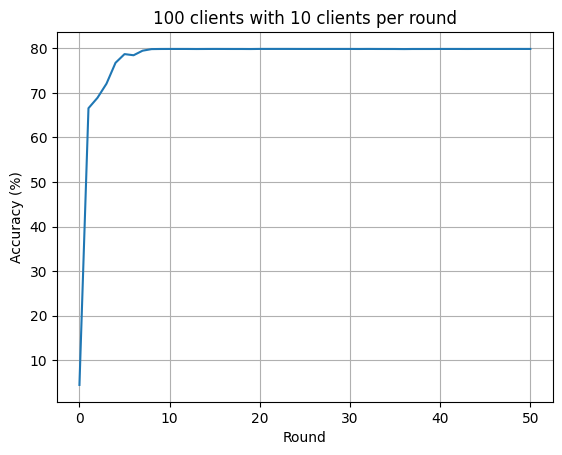

In [32]:
import math
from typing import Dict, List, Tuple

import tensorflow as tf

import flwr as fl
from flwr.common import Metrics
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth

VERBOSE = 0
NUM_CLIENTS = 100
count_rounds=0
number_of_rounds = 10



"""
#ANN
def get_model():

    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Flatten(input_shape=[9]),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(3, activation="softmax"),
        ]
    )
    global saving_model_name
    saving_model_name = "ann"
    model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
    return model
"""







"""
#CNN

def get_model():

  model = tf.keras.Sequential([
      tf.keras.layers.Dense(256, activation="relu", input_shape=(9,)),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(128, activation="relu"),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(64, activation="relu"),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(32, activation="relu"),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(3, activation="softmax"),
  ])
  global saving_model_name
  saving_model_name = "cnn"
  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  return model

"""





#LSTM

def get_model():
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, activation="relu", input_shape=(9, 1), return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(32, activation="relu", return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(3, activation="softmax")
    ])
    global saving_model_name
    saving_model_name = "lstm"

    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model











class FlowerClient(fl.client.NumPyClient):
    def __init__(self, x_train, y_train, x_val, y_val) -> None:
        # Create model
        self.model = get_model()
        self.x_train, self.y_train = x_train, y_train
        self.x_val, self.y_val = x_val, y_val

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(
            self.x_train, self.y_train, epochs=1, batch_size=32, verbose=VERBOSE
        )
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, acc = self.model.evaluate(
            self.x_val, self.y_val, batch_size=64, verbose=VERBOSE
        )
        return loss, len(self.x_val), {"accuracy": acc}


def get_client_fn(dataset_partitions):
    """Return a function to be executed by the VirtualClientEngine in order to construct
    a client."""

    def client_fn(cid: str) -> fl.client.Client:
        """Construct a FlowerClient with its own dataset partition."""

        # Extract partition for client with id = cid
        x_train, y_train = dataset_partitions[int(cid)]
        # Use 10% of the client's training data for validation
        split_idx = math.floor(len(x_train) * 0.9)
        x_train_cid, y_train_cid = (
            x_train[:split_idx],
            y_train[:split_idx],
        )
        x_val_cid, y_val_cid = x_train[split_idx:], y_train[split_idx:]

        # Create and return client
        return FlowerClient(x_train_cid, y_train_cid, x_val_cid, y_val_cid)

    return client_fn



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


def partition_mnist():
    """Download and partitions the MNIST dataset."""
    # Assuming df is your DataFrame containing the dataset

    encoder = LabelEncoder()
    df['Type'] = encoder.fit_transform(df['Type'])
    X = df.iloc[:, 4:]
    y = df['Type']

    # Apply SMOTE to balance the dataset
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    print("Original dataset shape:", Counter(y))
    print("Resampled dataset shape:", Counter(y_resampled))

    x_train, x_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.33, random_state=0)
    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()
    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    testset = (x_test, y_test)
    print(type(x_train))
    partitions = []
    # We keep all partitions equal-sized in this example
    partition_size = math.floor(len(x_train) / NUM_CLIENTS)
    for cid in range(NUM_CLIENTS):
        # Split dataset into non-overlapping NUM_CLIENT partitions
        idx_from, idx_to = int(cid) * partition_size, (int(cid) + 1) * partition_size
        partitions.append((x_train[idx_from:idx_to] / 255.0, y_train[idx_from:idx_to]))
    return partitions, testset





def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """Aggregation function for (federated) evaluation metrics, i.e. those returned by
    the client's evaluate() method."""
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}


def get_evaluate_fn(testset):
    x_test, y_test = testset

    def evaluate(
        server_round: int,
        parameters: fl.common.NDArrays,
        config: Dict[str, fl.common.Scalar],
    ):
        model = get_model()  # Construct the model
        model.set_weights(parameters)  # Update model with the latest parameters
        loss, accuracy = model.evaluate(x_test, y_test, verbose=VERBOSE)
        global count_rounds
        global number_of_rounds

        print("-------------------________________________---------------",number_of_rounds-count_rounds)

        if number_of_rounds-count_rounds == 0:
            global saving_model_name
            model.save(saving_model_name+"_model.h5")  # Replace with your desired filename"""

        count_rounds+=1
        return loss, {"accuracy": accuracy}

    return evaluate



# Enable GPU growth in your main process
enable_tf_gpu_growth()

# Create dataset partitions (needed if your dataset is not pre-partitioned)
partitions, testset = partition_mnist()

# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.1,  # Sample 10% of available clients for training
    fraction_evaluate=0.05,  # Sample 5% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=int(
        NUM_CLIENTS * 0.75
    ),  # Wait until at least 75 clients are available
    evaluate_metrics_aggregation_fn=weighted_average,  # aggregates federated metrics
    evaluate_fn=get_evaluate_fn(testset),  # global evaluation function
)



# client needs exclusive access to these many resources in order to run
client_resources = {"num_cpus": 1, "num_gpus": 0.0}



# Start simulation
history = fl.simulation.start_simulation(
    client_fn=get_client_fn(partitions),
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=number_of_rounds),
    strategy=strategy,
    client_resources=client_resources,
    actor_kwargs={
        "on_actor_init_fn": enable_tf_gpu_growth  # Enable GPU growth upon actor init.
    },
)



import matplotlib.pyplot as plt

print(f"{history.metrics_centralized = }")

global_accuracy_centralised = history.metrics_centralized["accuracy"]
round = [data[0] for data in global_accuracy_centralised]
acc = [100.0 * data[1] for data in global_accuracy_centralised]
plt.plot(round, acc)
plt.grid(True)
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.title("100 clients with 10 clients per round")

#Model Evaluation

In [23]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support




def eva(loaded_model):
  x_test, y_test = testset
  loss, accuracy = loaded_model.evaluate(x_test, y_test)
  print("Accuracy:", accuracy)


  print("Loss:", loss)


  predicted_probabilities = loaded_model.predict(x_test)
  predictions = predicted_probabilities.argmax(axis=-1)

  precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, predictions, average='weighted')
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1-Score:", f1_score)

  # 4. Confusion Matrix evaluation
  conf_matrix = confusion_matrix(y_test, predictions)
  print("Confusion Matrix:\n", conf_matrix)




def ROC(loaded_model):
  # Transform labels to one-hot encoded format
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test_one_hot = lb.transform(y_test)

  # Get the predicted probabilities for each class
  predicted_probabilities = loaded_model.predict(x_test)

  # Compute the ROC curve and AUC score for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(len(lb.classes_)):
      fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], predicted_probabilities[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and AUC score
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test_one_hot.ravel(), predicted_probabilities.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # Plot ROC curve

  plt.figure(figsize=(12, 10))
  plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

  for i in range(len(lb.classes_)):
      plt.plot(fpr[i], tpr[i], lw=2,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')  # Increase size and make bold
  plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')  # Increase size and make bold

  plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, fontweight='bold')  # Increase size and make bold
  plt.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'})  # Increase size and make bold
  plt.grid(True)  # Add grid

  plt.xticks(fontsize=12, fontweight='bold')  # Increase size and make bold
  plt.yticks(fontsize=12, fontweight='bold')  # Increase size and make bold

  plt.grid(True)  # Add grid
  plt.show()


In [24]:
from tensorflow.keras.models import load_model
loaded_model = load_model("/content/final_model.h5")

In [25]:
eva(loaded_model)

9166/9166 [==============================] - 17s 2ms/step - loss: 636.7599 - accuracy: 0.7985
Accuracy: 0.7984930872917175
Loss: 636.7599487304688
9166/9166 [==============================] - 15s 2ms/step
Precision: 0.7922795201573517
Recall: 0.7984930619481095
F1-Score: 0.7638779747111176
Confusion Matrix:
 [[     0      0  13112]
 [     0  43724  44281]
 [     0   1711 190482]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9166/9166 [==============================] - 15s 2ms/step


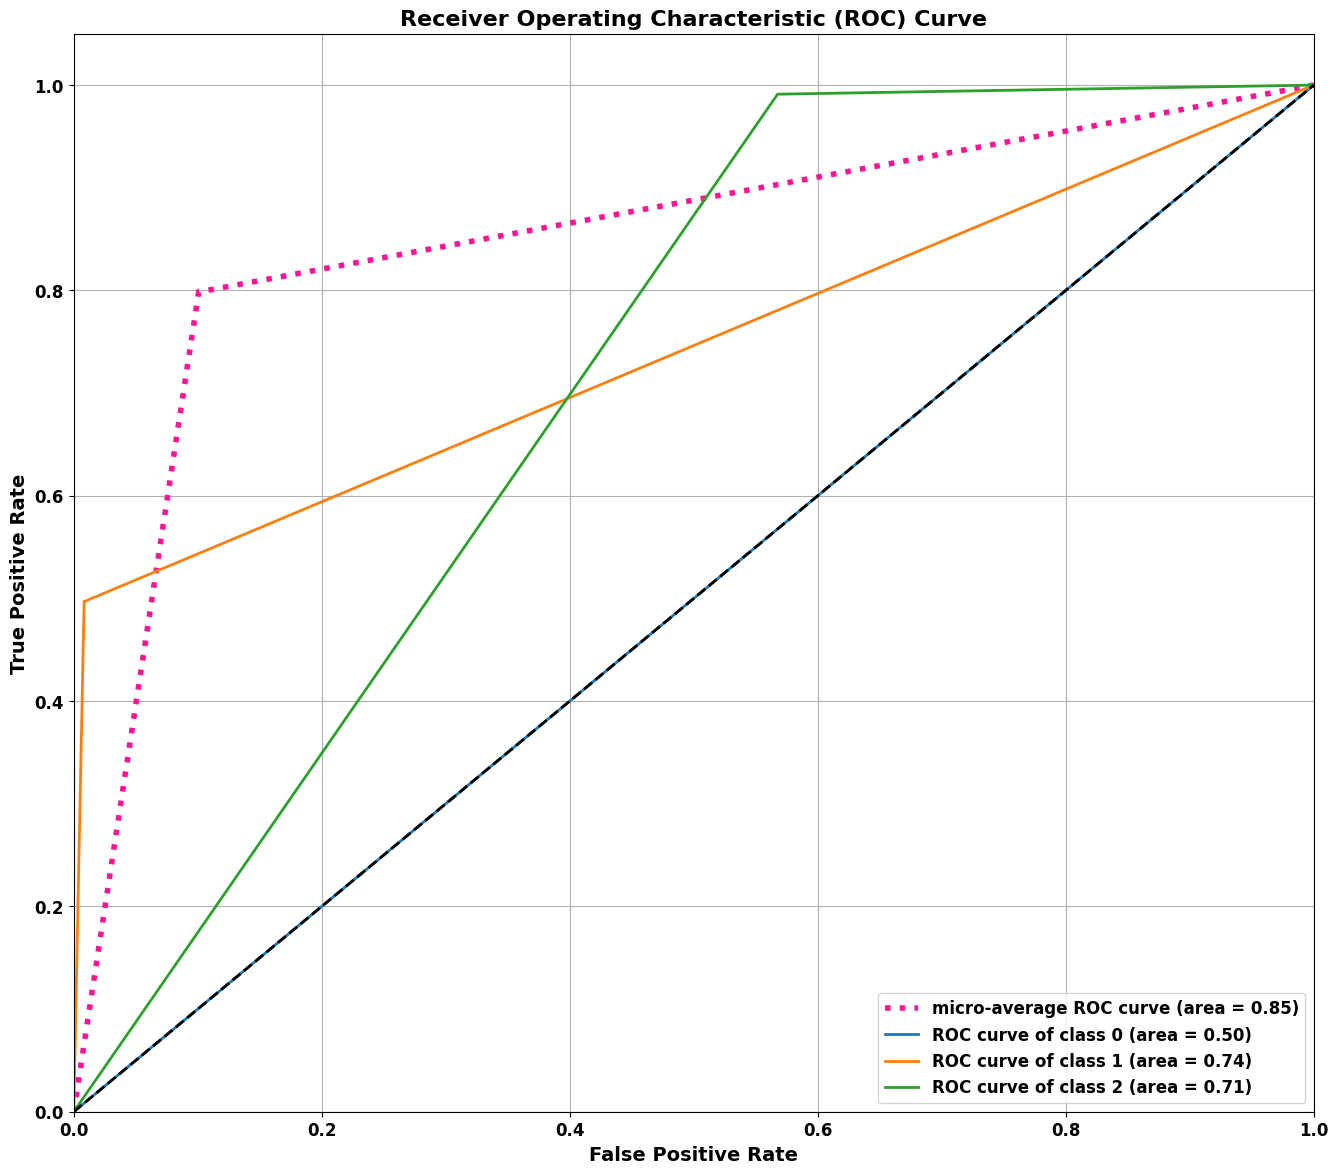

In [26]:
ROC(loaded_model)